In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
# for tensorboard
from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "AND_logs"
logdir = "{}/run-{}/".format(root_logdir,now)
#-------------------
sns.set()
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

# D. Cashon

<h2>Extract MNIST data</h2>

In [21]:
from tensorflow.examples.tutorials.mnist import input_data
#get mnist data, with one_hot encoding
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
#suppress warnings
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [22]:
train_imgs = mnist.train.images
train_labels = mnist.train.labels
test_imgs = mnist.test.images
test_labels = mnist.test.labels

<h2>Define hyperparameters</h2>

In [23]:
num_iter = 1000 # to vary later
lr = 0.01 # to vary later
n_per_layer = [256, 128, 64]
num_layers = len(n_per_layer)
batch_size = 64

<h2>Define placeholder and Variables</h2>

In [24]:
# input layer is invariant
tf.reset_default_graph()
x_in = tf.placeholder(dtype=tf.float32, shape=[None, 784])

# define true labels
y_hat = tf.placeholder(dtype=tf.float32, shape=[None, 10])

weights, biases = {}, {}
for i in range(num_layers):
    wkey = 'W' + str(i)
    bkey = 'B' + str(i)
    if i == 0:
        # first layer, use input dim
        weights[wkey] = tf.get_variable(wkey, shape=[784, n_per_layer[i]])
        biases[bkey] = tf.get_variable(bkey, shape=[1,1])
    else:
        # other layers, use dim and dim-1
        weights[wkey] = tf.get_variable(wkey, shape=[n_per_layer[i-1], n_per_layer[i]])
        biases[bkey] = tf.get_variable(bkey, shape=[1,1])

# add output layer weight and bias
wkey_out = 'W' + str(num_layers)
bkey_out = 'B' + str(num_layers)
weights[wkey_out] = tf.get_variable(wkey_out, shape=[n_per_layer[num_layers-1], 10])
biases[bkey_out] = tf.get_variable(bkey_out, shape=[1,1])


<h2>Define neural network</h2>

In [25]:
# for now sigmoid activation, but will try others too
layers_out = []
for i, wb in enumerate(list(zip(weights, biases))):
    if i == 0:
        # first layer, needs x_in
        layers_out.append(tf.nn.sigmoid(tf.add(tf.matmul(x_in, weights[wb[0]]), biases[wb[1]])))
    else:
        layers_out.append(tf.nn.sigmoid(tf.add(tf.matmul(layers_out[i-1], weights[wb[0]]), biases[wb[1]])))
logits = layers_out[-1]

<h2>Define cost function and accuracy</h2>

In [27]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_hat))
#define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(cost)

#compare the predicted labels with true labels
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y_hat,1))

#compute the accuracy by taking average
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

# tensorboard
file_writer = tf.summary.FileWriter(logdir,tf.get_default_graph())


<h2>Execute training</h2>

Sample Test Accuracy 	 0.03125
Accuracy 	 0.140625
Cost 	2.2758887
Sample Test Accuracy 	 0.796875
Accuracy 	 0.796875
Cost 	1.5730338
Sample Test Accuracy 	 0.59375
Accuracy 	 0.59375
Cost 	1.6257637
Sample Test Accuracy 	 0.71875
Accuracy 	 0.734375
Cost 	1.5781505
Sample Test Accuracy 	 0.78125
Accuracy 	 0.828125
Cost 	1.6006204
Sample Test Accuracy 	 0.9375
Accuracy 	 0.890625
Cost 	1.5633004
Sample Test Accuracy 	 0.96875
Accuracy 	 0.96875
Cost 	1.492963
Sample Test Accuracy 	 0.953125
Accuracy 	 0.96875
Cost 	1.4981754
Sample Test Accuracy 	 0.953125
Accuracy 	 0.953125
Cost 	1.5098767
Sample Test Accuracy 	 0.96875
Accuracy 	 nan
Cost 	nan
CPU times: user 1.5 s, sys: 191 ms, total: 1.69 s
Wall time: 1.68 s


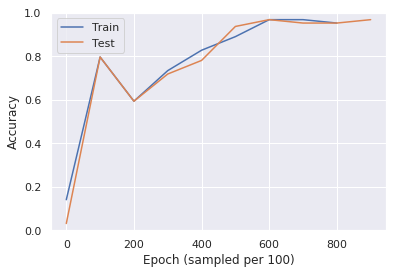

In [28]:
%%time
init = tf.global_variables_initializer()
epoch, train_acc, test_acc = [], [], []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_iter):
        # assuming we dont get to the end before num_epochs finishes
        batch_start = i * batch_size
        batch_end = i * batch_size + batch_size
        # train
        sess.run(train_op, feed_dict={x_in: train_imgs[batch_start:batch_end, :], y_hat: train_labels[batch_start:batch_end, :]})
        if i % 100 == 0:
            # print accuracy
            acc = sess.run(accuracy, feed_dict={x_in: train_imgs[batch_start:batch_end, :], y_hat: train_labels[batch_start:batch_end, :]})
            cst = sess.run(cost, feed_dict={x_in: train_imgs[batch_start:batch_end, :], y_hat: train_labels[batch_start:batch_end, :]})
            test_a = sess.run(accuracy, feed_dict={x_in: test_imgs[batch_size:2*batch_size, :], y_hat: test_labels[batch_size:2*batch_size, :]})
            print('Sample Test Accuracy \t ' + str(test_a))
            print('Accuracy \t ' + str(acc))
            print('Cost \t' + str(cst))
            epoch.append(i)
            train_acc.append(acc)
            test_acc.append(test_a)
file_writer.close()
plt.figure(1)
plt.plot(epoch, train_acc, label='Train')
plt.plot(epoch, test_acc, label='Test')
plt.grid(True)
plt.xlabel('Epoch (sampled per 100)')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()

<h2>Your results</h2>

I wrote a function to vary parameters and then a python script to create the visualizations. Please see:

HW1_mnist_vary.py
HW1_mnist_function.py

